# Основная задача

## Импорт необходимых библиотек

In [1]:
!pip install category_encoders
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import itertools
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from category_encoders import TargetEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

LARGE, MEDIUM, SMALL = 22, 16, 12

PARAMS = {'axes.titlesize': LARGE,
          'legend.fontsize': MEDIUM,
          'figure.figsize': (16, 10),
          'axes.labelsize': MEDIUM,
          'axes.titlesize': MEDIUM,
          'xtick.labelsize': MEDIUM,
          'ytick.labelsize': MEDIUM,
          'figure.titlesize': LARGE}

plt.rcParams.update(PARAMS)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_style("white")

## Сбор данных

In [4]:
credit_train = pd.read_csv("credit_train.csv",
                           sep=';',
                           encoding="cp1251")

credit_test = pd.read_csv("credit_test.csv",
                          sep=';',
                          encoding="cp1251")

# из описания задания: замена запятых на точки
credit_train['score_shk'] = credit_train['score_shk'].str.replace(',', '.').astype(float)
credit_train['credit_sum'] = credit_train['credit_sum'].str.replace(',', '.').astype(float)

credit_test['score_shk'] = credit_test['score_shk'].str.replace(',', '.').astype(float)
credit_test['credit_sum'] = credit_test['credit_sum'].str.replace(',', '.').astype(float)

## Анализ данных

На этом этапе сделаем копию тренировочной выборки для того, чтобы эксперименты с данными не повлияли на исходную тренировочную выборку:

In [5]:
credits = credit_train.copy()

Посмотрим на данные с высоты птичьего полета, чтобы узнать, с чем мы имеем дело:

In [6]:
credits

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,59998.00,10,1.60,0.770249,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,10889.00,6,1.10,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,10728.00,12,1.10,0.459589,SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,12009.09,12,1.10,0.362536,GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,16908.89,10,1.10,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,64867.00,12,1.10,0.535257,GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24,MAR,SPC,17640.00,6,1.60,0.573287,SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31,UNM,SPC,27556.47,10,1.32,0.416098,GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53,DIV,PNA,6189.00,12,1.10,0.482595,SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


* В данных присутствуют как **категориальные** признаки, так и **количественные**;
* Целевым признаком является `open_account_flg`, который принимает бинарные значения: `0` или `1` (одобрен ли кредит);
* Общее количество данных в тренировочной выборке составляет порядка 170 тыс., количество признаков - 14 (включая целевую переменную);
* Клиентами являются, судя по значениям признака `living_region`, **граждане РФ**;
* Значения признака `client_id`, скорее всего, являются **уникальными**;

Проверим, является числовой признак `client_id` уникальным:

In [7]:
credits['client_id'].is_unique

True

Да! Учтем это - чуть позже проставим индексацию обучающей выборки по значениям этого признака. Теперь немного подробнее ознакомимся с типами признаков, а также посмотрим, присутствуют ли в данных пропущенные значения:

In [8]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170746 non-null  int64  
 3   marital_status        170746 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170746 non-null  float64
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  float64
 8   score_shk             170746 non-null  float64
 9   education             170746 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170745 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

* По причине того, что признаки имеют *жирные* типы данных (`int64`, `float64`, `object`), используемая память составляет чуть более 19 мб - для ускорения работы алгоритмов машинного обучения и высвобождения памяти следует преобразовать типы данных в более легкие, которые будут соответствовать значениям признаков (например, возраст клиента вряд ли превысит 128 лет, поэтому `int64` можно преобразовать в `int8`);
* В данных присутствуют пропуски (например, в столбцах `credit_count` и `overdue_credit_count` порядка 10 тысяч пропусков).

Посмотрим на статистические показатели значений числовых признаков:

In [9]:
credits.describe()

,client_id,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,170746.000000,170746.000000,170746.000000,170746.000000,170746.000000,170746.000000,170745.000000,161516.000000,161516.000000,170746.000000
mean,85373.500000,36.497283,26095.047799,10.980749,1.323900,0.469473,40138.288354,2.107308,0.046070,0.176028
std,49290.268869,10.546008,16234.794320,3.536698,0.235813,0.124268,25044.205336,1.777128,0.211548,0.380845
min,1.000000,18.000000,2736.000000,3.000000,1.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,42687.250000,28.000000,14908.000000,10.000000,1.100000,0.379495,25000.000000,1.000000,0.000000,0.000000
50%,85373.500000,34.000000,21229.000000,10.000000,1.320000,0.461599,35000.000000,2.000000,0.000000,0.000000
75%,128059.750000,43.000000,32068.000000,12.000000,1.600000,0.552419,50000.000000,3.000000,0.000000,0.000000
max,170746.000000,71.000000,200000.000000,36.000000,1.960000,1.128291,950000.000000,21.000000,3.000000,1.000000


* Кредиты одобряются с 18 лет, максимальный возраст клиента - 71 год, при этом в 75% перцентиле находятся клиенты с возрастом < 45.
* Среднемесячная сумма кредита составляет примерно **2500 руб.**, что составляет примерно **6% от средней зарплаты**;
* Доля одобренных кредитов составляет 18% - в данных возможно **имбаланс классов** бинарной классификации.

Рассмотрим также статистические показатели категориальных признаков:

In [10]:
credits.describe(include='object')

,gender,marital_status,job_position,education,living_region
count,170746,170746,170746,170746,170554
unique,2,5,18,5,301
top,F,MAR,SPC,SCH,ОБЛ МОСКОВСКАЯ
freq,88697,93956,134680,87539,12228


* Самый популярный регион подачи заявления на одобрение кредита - **Московская область**;

Теперь посмотрим на распределения числовых признаков (в разрезе уникальных значений целевой переменной):

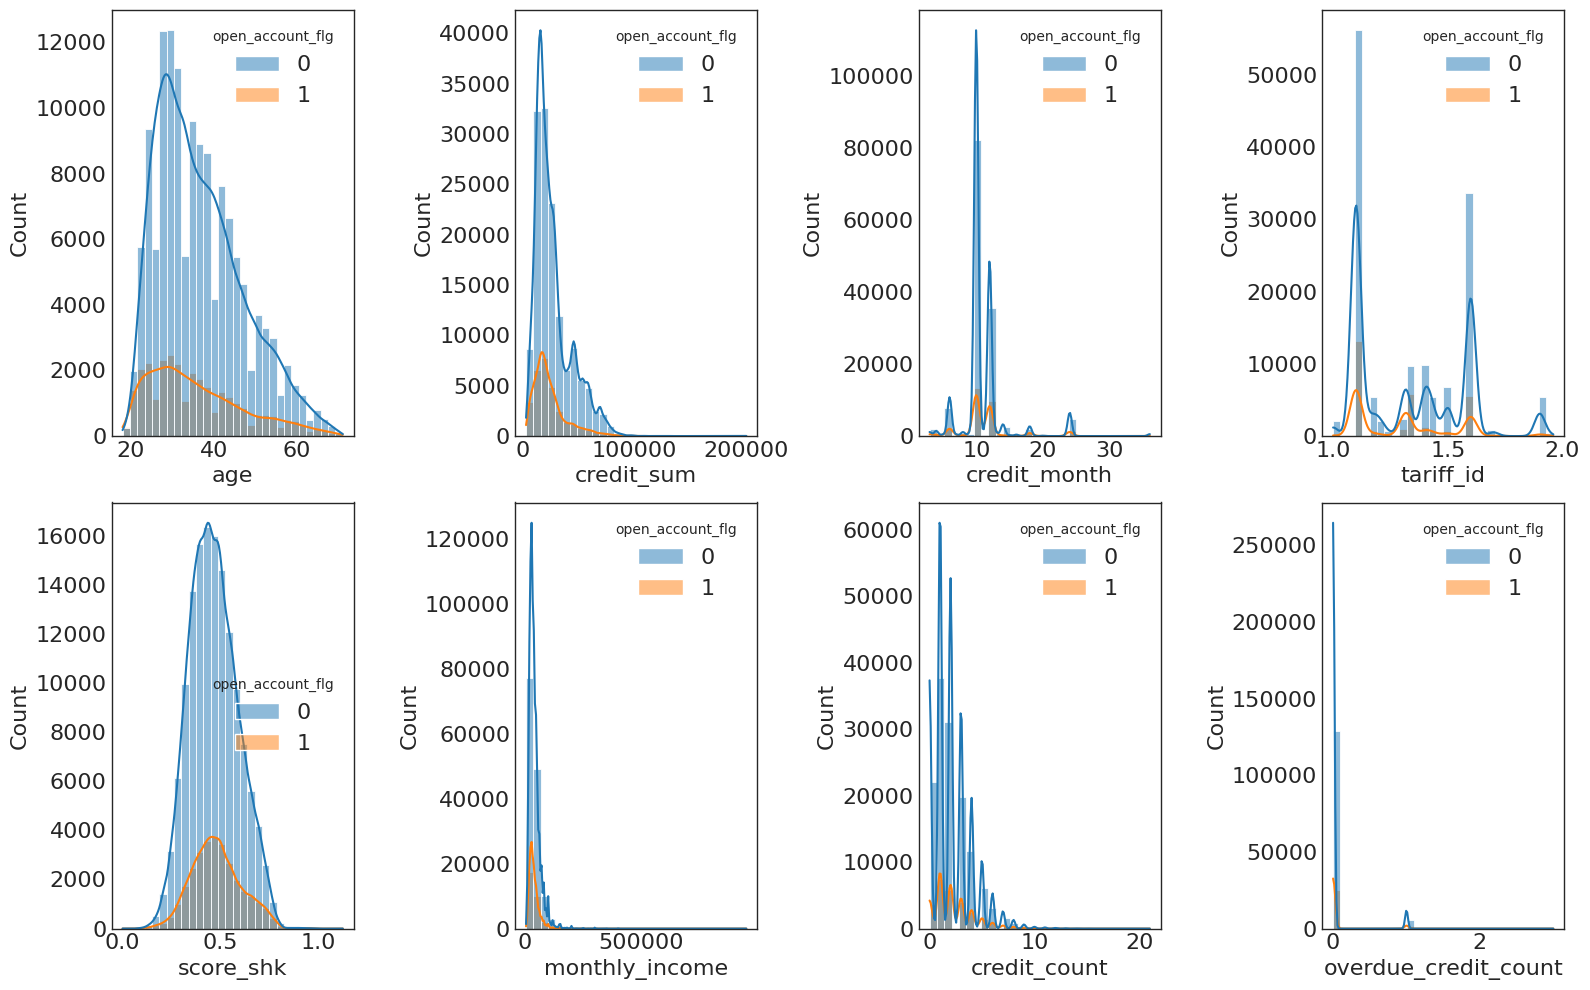

In [11]:
num_features = [
    'age',
    'credit_sum',
    'credit_month',
    'tariff_id', 'score_shk',
    'monthly_income', 'credit_count',
    'overdue_credit_count'
]

N_ROWS = 2
N_COLS = 4

fig, axes = plt.subplots(N_ROWS, N_COLS)

for idx, ax in enumerate(axes.flatten()):
    sns.histplot(
        data=credits,
        x=num_features[idx],
        kde=True,
        bins=30,
        hue='open_account_flg',
        ax=ax
    )

fig.tight_layout()
plt.show()

* Числовые признаки `credit_month`, `tariff_id`, `credit_count`, `overdue_credit_count`на самом деле являются **категориальными** - судя по графику, они принимают несколько значений с определенной частотой;
* В данных точно присутствует **имбаланс классов**, это видно из распределений признаков.

Теперь поработаем с пропущенными значениями. Для начала создадим удобную таблицу пропусков:

In [12]:
total_nulls = credit_train.isnull().sum()
total_nulls_percentage = total_nulls * 100 / len(credit_train)
pd.concat([total_nulls, total_nulls_percentage],
          keys=['rows (total)', 'rows (percentage)'],
          axis=1)

,rows (total),rows (percentage)
client_id,0,0.000000
gender,0,0.000000
age,0,0.000000
marital_status,0,0.000000
job_position,0,0.000000
credit_sum,0,0.000000
credit_month,0,0.000000
tariff_id,0,0.000000
score_shk,0,0.000000
education,0,0.000000


Рассмотрим признак `living_region` - регион проживания клиента. Посмотрим на уникальное количество регионов в данных:

In [13]:
credits['living_region'].value_counts().head(30)

ОБЛ МОСКОВСКАЯ                              12228
КРАСНОДАРСКИЙ КРАЙ                           7457
САНКТ-ПЕТЕРБУРГ                              5632
МОСКВА                                       5529
ТАТАРСТАН РЕСП                               5187
РЕСП БАШКОРТОСТАН                            4833
ОБЛ ИРКУТСКАЯ                                4080
СВЕРДЛОВСКАЯ ОБЛ                             4006
МОСКВА Г                                     3647
ОБЛ НИЖЕГОРОДСКАЯ                            3555
ОБЛ ЛЕНИНГРАДСКАЯ                            3229
РОСТОВСКАЯ ОБЛ                               3026
КРАСНОЯРСКИЙ КРАЙ                            2929
ЧЕЛЯБИНСКАЯ ОБЛ                              2904
ОБЛ САМАРСКАЯ                                2842
ОБЛ КЕМЕРОВСКАЯ                              2828
ПЕРМСКИЙ КРАЙ                                2716
САНКТ-ПЕТЕРБУРГ Г                            2633
КРАЙ СТАВРОПОЛЬСКИЙ                          2624
ОБЛ АСТРАХАНСКАЯ                             2520


Ого! В данных дублируются названия регионов из-за того, что информация скорее всего занесена в данные **неправильно** (или возможно такова **особенность данных**). Посмотрим на уникальные значения данного признака:

In [14]:
credits['living_region'].unique()

array(['КРАСНОДАРСКИЙ КРАЙ', 'МОСКВА', 'ОБЛ САРАТОВСКАЯ',
       'ОБЛ ВОЛГОГРАДСКАЯ', 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ', 'СТАВРОПОЛЬСКИЙ КРАЙ',
       'ОБЛ НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ ОБЛ',
       'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА', 'КРАЙ СТАВРОПОЛЬСКИЙ',
       'САНКТ-ПЕТЕРБУРГ', 'РЕСП. БАШКОРТОСТАН', 'ОБЛ АРХАНГЕЛЬСКАЯ',
       'ХАНТЫ-МАНСИЙСКИЙ АО', 'РЕСП БАШКОРТОСТАН', 'ПЕРМСКИЙ КРАЙ',
       'РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'САРАТОВСКАЯ ОБЛ', 'ОБЛ КАЛУЖСКАЯ',
       'ОБЛ ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ ОБЛ', 'УДМУРТСКАЯ РЕСП',
       'ОБЛ ИРКУТСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ОБЛ МОСКОВСКАЯ',
       'ОБЛ ТЮМЕНСКАЯ', 'ОБЛ БЕЛГОРОДСКАЯ', 'РОСТОВСКАЯ ОБЛАСТЬ',
       'ОБЛ КОСТРОМСКАЯ', 'РЕСП ХАКАСИЯ', 'РЕСПУБЛИКА ТАТАРСТАН',
       'ИРКУТСКАЯ ОБЛАСТЬ', 'ОБЛ СВЕРДЛОВСКАЯ', 'ОБЛ ПСКОВСКАЯ',
       'КРАЙ ЗАБАЙКАЛЬСКИЙ', 'СВЕРДЛОВСКАЯ ОБЛ', 'ОБЛ ОРЕНБУРГСКАЯ',
       'ОБЛ ВОРОНЕЖСКАЯ', 'ОБЛ АСТРАХАНСКАЯ', 'ОБЛ НОВОСИБИРСКАЯ',
       'ОБЛ ЧЕЛЯБИНСКАЯ', 'ОРЕНБУРГСКАЯ ОБЛ', 'СВЕРДЛОВСКАЯ ОБЛАСТЬ'

Мы используем данную информацию на этапе подготовки данных. По поводу пропущенных значений - просто **замением пропущенные категории** отдельным значением (`UNKNOWN`) - возможно пропущенные значения просто означают, что информации о клиенте нет.

Рассмотрим теперь признаки `credit_count` и `overdue_credit_count`, которые содержат 5% пропущенных значений:

In [15]:
credits[pd.isna(credits['credit_count'])]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
25,26,F,22,UNM,SPC,30000.0,18,1.10,0.550770,UGR,РЕСП. БАШКОРТОСТАН,30000.0,NaN,NaN,1
50,51,F,35,MAR,SPC,13779.0,10,1.60,0.677837,GRD,ОБЛ НОВОСИБИРСКАЯ,28000.0,NaN,NaN,0
52,53,F,33,DIV,DIR,15379.2,10,1.22,0.566717,GRD,САНКТ-ПЕТЕРБУРГ,60000.0,NaN,NaN,0
72,73,M,21,UNM,ATP,14309.0,10,1.10,0.293619,SCH,МОСКВА,30000.0,NaN,NaN,1
74,75,F,27,MAR,SPC,15248.0,10,1.60,0.591578,SCH,ОРЕНБУРГСКАЯ ОБЛ,10000.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170638,170639,M,31,MAR,SPC,31618.0,24,1.10,0.657404,UGR,ОБЛ КИРОВСКАЯ,40000.0,NaN,NaN,0
170686,170687,M,22,UNM,SPC,4430.0,6,1.40,0.699623,UGR,ОБЛ НОВОСИБИРСКАЯ,15200.0,NaN,NaN,1
170698,170699,F,20,UNM,SPC,5366.0,6,1.90,0.620990,SCH,БАШКОРТОСТАН,17000.0,NaN,NaN,1
170727,170728,F,25,CIV,SPC,15490.0,6,1.40,0.351099,GRD,ОБЛ МОСКОВСКАЯ,27000.0,NaN,NaN,0


In [16]:
credits[pd.isna(credits['overdue_credit_count'])]

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
25,26,F,22,UNM,SPC,30000.0,18,1.10,0.550770,UGR,РЕСП. БАШКОРТОСТАН,30000.0,NaN,NaN,1
50,51,F,35,MAR,SPC,13779.0,10,1.60,0.677837,GRD,ОБЛ НОВОСИБИРСКАЯ,28000.0,NaN,NaN,0
52,53,F,33,DIV,DIR,15379.2,10,1.22,0.566717,GRD,САНКТ-ПЕТЕРБУРГ,60000.0,NaN,NaN,0
72,73,M,21,UNM,ATP,14309.0,10,1.10,0.293619,SCH,МОСКВА,30000.0,NaN,NaN,1
74,75,F,27,MAR,SPC,15248.0,10,1.60,0.591578,SCH,ОРЕНБУРГСКАЯ ОБЛ,10000.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170638,170639,M,31,MAR,SPC,31618.0,24,1.10,0.657404,UGR,ОБЛ КИРОВСКАЯ,40000.0,NaN,NaN,0
170686,170687,M,22,UNM,SPC,4430.0,6,1.40,0.699623,UGR,ОБЛ НОВОСИБИРСКАЯ,15200.0,NaN,NaN,1
170698,170699,F,20,UNM,SPC,5366.0,6,1.90,0.620990,SCH,БАШКОРТОСТАН,17000.0,NaN,NaN,1
170727,170728,F,25,CIV,SPC,15490.0,6,1.40,0.351099,GRD,ОБЛ МОСКОВСКАЯ,27000.0,NaN,NaN,0


Получается, что если нет информации о признаке `credit_count`, то и нет информации о `overdue_credit_count`. Скорее всего это не просто так, так как все остальные значения совпадают - не возникает ситуации, когда один из признаков не имеет значения, а другой - имеет. Поступим так же, как и с `living_region` - заменим **пропущенные значения на отдельную категорию** (из анализа данных чуть выше мы заметили, что эти признаки можно использовать как категориальные, они принимают вcего несколько значений).

Последний пропущенный признак `monthly_income` имеет всего один пропуск. Можем заменить его на **медиану/среднее**, вряд ли из-за одного пропуска у нас возникнет смещение.

## Подготовка данных

In [17]:
credits = credit_train.copy()

credits = credits.set_index("client_id")
credits, credits_label = credits.drop(columns=['open_account_flg']), credits['open_account_flg']

### Очистка данных

**Ошибки в данных**

В данном разделе подчистим признак `living_region` (см. этап анализа данных).

In [18]:
keywords = (
    'ОБЛАСТЬ ', ' ОБЛАСТЬ',
    'РЕСПУБЛИКА ', ' РЕСПУБЛИКА',
    'ОБЛ. ', ' ОБЛ.', 'ОБЛ.', 'ОБЛ ', ' ОБЛ',
    'РЕСП. ', ' РЕСП.', 'РЕСП.', 'РЕСП ', ' РЕСП',
    'Г. ', ' Г.', 'Г.', 'Г ', ' Г',
    'КРАЙ. ', ' КРАЙ.', 'КРАЙ.', 'КРАЙ ', ' КРАЙ',
    ' (ЯКУТИЯ)', '(ЯКУТИЯ) ', '/ЯКУТИЯ/ ', ' /ЯКУТИЯ/',
    'АВТОНОМНЫЙ ОКРУ- ЮГРА ', ' АВТОНОМНЫЙ ОКРУ- ЮГРА',
    'АВТОНОМНЫЙ ОКРУГ - Ю ', ' АВТОНОМНЫЙ ОКРУГ - Ю',
    'АВТОНОМНЫЙ ОКРУ- Ю ', ' АВТОНОМНЫЙ ОКРУ- Ю',
    'АО ', ' АО'
)

for keyword in keywords:
    credits['living_region'] = credits['living_region'].str.replace(
        keyword, '', regex=False
    )

In [19]:
keywords_to_keywords = {
    'РЕСПУБЛИКАТАТАРСТАН': 'ТАТАРСТАН',
    'АЕВРЕЙСКАЯ': 'ЕВРЕЙСКАЯ',
    'ЕВРЕЙСКАЯ АВТОНОМНАЯ': 'ЕВРЕЙСКАЯ',
    'ЕВРЕЙСКАЯБЛ': 'ЕВРЕЙСКАЯ',
    'СЕВ. ОСЕТИЯ - АЛАНИЯ': 'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
    'ЧУВАШИЯ ЧУВАШСКАЯ -': 'ЧУВАШСКАЯ',
    'ЧУВАШСКАЯ - ЧУВАШИЯ': 'ЧУВАШСКАЯ',
    'МОСКВОСКАЯ': 'МОСКОВСКАЯ'
}

for key in keywords_to_keywords:
    value = keywords_to_keywords[key]
    credits['living_region'] = credits['living_region'].str.replace(
        key, value, regex=False
    )

credits['living_region'] = credits['living_region'].str.strip()

In [20]:
credits.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
client_id,,,,,,,,,,,,,
1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0
2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0
3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,САРАТОВСКАЯ,23000.0,5.0,0.0
4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0
5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,25000.0,1.0,0.0


**Пропущенные значения в данных**

Заменим пропущенные значения на отдельные категории для категориальных признаков (в частности, для `living_region`, `credit_count`, `overdue_credit_count`):

In [21]:
categorical_features = [
    'gender', 'marital_status', 'job_position', 'credit_month',
    'tariff_id', 'education', 'living_region', 'credit_count',
    'overdue_credit_count'
]

credits[categorical_features] = credits[categorical_features].astype(object)
credits[categorical_features] = credits[categorical_features].fillna(
    'UNKNOWN'
)

Заменим пропущенные значения на медианы для числовых признаков (в частности, для `monthly_income`):

In [22]:
numerical_features = ['age', 'credit_sum', 'score_shk', 'monthly_income']

credits[numerical_features] = credits[numerical_features].fillna(
    credits[numerical_features].median()
)

Убедимся, что все пропущенные значения заполнены:

In [23]:
total_nulls = credits.isnull().sum()
total_nulls_percentage = total_nulls * 100 / len(credits)
pd.concat([total_nulls, total_nulls_percentage],
          keys=['rows (total)', 'rows (percentage)'],
          axis=1)

,rows (total),rows (percentage)
gender,0,0.0
age,0,0.0
marital_status,0,0.0
job_position,0,0.0
credit_sum,0,0.0
credit_month,0,0.0
tariff_id,0,0.0
score_shk,0,0.0
education,0,0.0
living_region,0,0.0


### Преобразование признаков в данных

**Генерация новых признаков**

Сгенерируем признаки по количественным признакам - **всякие статистические показатели по значениям соответствующих признаков**. Дополнительно сформируем интуитивно понятные признаки, такие как **ежемесячная сумма кредита, отношение зарплаты к возрасту** (в идеале должны быть паттерны "одинаковости" - ведь с увеличением возраста обычно должна увеличиваться зарплата) и **отношение зарплаты к ежемесячной сумме кредита** (там, где это отношение больше - менее рискованные клиенты).

In [24]:
for num_feature in numerical_features:
    credits['FEATURE_1'] = credits['credit_sum'] / credits['credit_month'].astype(float)
    credits['FEATURE_2'] = credits['monthly_income'] / credits['age']
    credits['FEATURE_3'] = credits['score_shk'].astype(float) * credits['monthly_income']

    credits[f'{num_feature}_mean'] = np.mean(credits[num_feature])
    credits[f'{num_feature}_max'] = np.max(credits[num_feature])
    credits[f'{num_feature}_min'] = np.min(credits[num_feature])
    credits[f'{num_feature}_std'] = np.std(credits[num_feature])
    credits[f'{num_feature}_var'] = np.var(credits[num_feature])
    credits[f'{num_feature}_ptp'] = np.ptp(credits[num_feature])
    credits[f'{num_feature}_percentile_5'] = np.percentile(credits[num_feature], 5)
    credits[f'{num_feature}_percentile_15'] = np.percentile(credits[num_feature], 15)
    credits[f'{num_feature}_percentile_30'] = np.percentile(credits[num_feature], 30)
    credits[f'{num_feature}_percentile_45'] = np.percentile(credits[num_feature], 45)
    credits[f'{num_feature}_percentile_60'] = np.percentile(credits[num_feature], 60)
    credits[f'{num_feature}_percentile_75'] = np.percentile(credits[num_feature], 75)
    credits[f'{num_feature}_percentile_95'] = np.percentile(credits[num_feature], 95)

Сгенерировать признаки по качественным признакам можно их обычной конкатенацией/частотой по отдельным группам. Используем **конкатенацию разных категориальных признаков в разрезе каждого клиента**, частоты трогать не будем (это увеличит количество признаков, но у меня к сожалению вычислительных ресурсов и времени не очень много, по идее после первого метода сразу использовать второй, а потом с помощью методов отбора признаков оставить наилучшие, но грамотные методы такие, как отбор по метрике, осуществляется долго на моем монстре - от 10 часов).

In [25]:
combinations = list(itertools.combinations(categorical_features, 2))
for c1, c2 in combinations:
    credits.loc[:, c1 + "_" + c2] = credits[c1].astype(str) + "_" + credits[c2].astype(str)

> Использовать `.join()` не получилось - `RAM` вылетает. Поэтому как-то так.

In [26]:
credits.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,...,tariff_id_education,tariff_id_living_region,tariff_id_credit_count,tariff_id_overdue_credit_count,education_living_region,education_credit_count,education_overdue_credit_count,living_region_credit_count,living_region_overdue_credit_count,credit_count_overdue_credit_count
client_id,,,,,,,,,,,,,,,,,,,,,
1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,КРАСНОДАРСКИЙ,...,1.6_GRD,1.6_КРАСНОДАРСКИЙ,1.6_1.0,1.6_1.0,GRD_КРАСНОДАРСКИЙ,GRD_1.0,GRD_1.0,КРАСНОДАРСКИЙ_1.0,КРАСНОДАРСКИЙ_1.0,1.0_1.0
2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,МОСКВА,...,1.1_GRD,1.1_МОСКВА,1.1_2.0,1.1_0.0,GRD_МОСКВА,GRD_2.0,GRD_0.0,МОСКВА_2.0,МОСКВА_0.0,2.0_0.0
3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,САРАТОВСКАЯ,...,1.1_SCH,1.1_САРАТОВСКАЯ,1.1_5.0,1.1_0.0,SCH_САРАТОВСКАЯ,SCH_5.0,SCH_0.0,САРАТОВСКАЯ_5.0,САРАТОВСКАЯ_0.0,5.0_0.0
4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,ВОЛГОГРАДСКАЯ,...,1.1_GRD,1.1_ВОЛГОГРАДСКАЯ,1.1_2.0,1.1_0.0,GRD_ВОЛГОГРАДСКАЯ,GRD_2.0,GRD_0.0,ВОЛГОГРАДСКАЯ_2.0,ВОЛГОГРАДСКАЯ_0.0,2.0_0.0
5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,...,1.1_SCH,1.1_ЧЕЛЯБИНСКАЯ,1.1_1.0,1.1_0.0,SCH_ЧЕЛЯБИНСКАЯ,SCH_1.0,SCH_0.0,ЧЕЛЯБИНСКАЯ_1.0,ЧЕЛЯБИНСКАЯ_0.0,1.0_0.0


Далее нам нужно закодировать категориальные признаки и отмасштабировать все признаки.

**Кодирование категориальных признаков в числовые**

In [27]:
target_encoder = TargetEncoder(
    cols=credits.select_dtypes(include=['object']).columns,
    return_df=True
)
credits = target_encoder.fit_transform(credits, credits_label)

In [28]:
credits.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,...,tariff_id_education,tariff_id_living_region,tariff_id_credit_count,tariff_id_overdue_credit_count,education_living_region,education_credit_count,education_overdue_credit_count,living_region_credit_count,living_region_overdue_credit_count,credit_count_overdue_credit_count
client_id,,,,,,,,,,,,,,,,,,,,,
1,0.193555,48,0.152923,0.188978,59998.00,10,1.6,0.770249,0.139543,0.200359,...,0.087196,0.147451,0.129854,0.156882,0.156842,0.131537,0.182361,0.187225,0.254902,0.227960
2,0.159814,28,0.152923,0.188978,10889.00,6,1.1,0.248514,0.139543,0.206997,...,0.140512,0.215182,0.168820,0.176534,0.175924,0.130690,0.132991,0.185881,0.189086,0.155920
3,0.193555,32,0.152923,0.166342,10728.00,12,1.1,0.459589,0.205120,0.177038,...,0.230206,0.175275,0.189765,0.176534,0.208299,0.210032,0.188114,0.197784,0.164883,0.179093
4,0.159814,27,0.182086,0.166342,12009.09,12,1.1,0.362536,0.139543,0.181703,...,0.140512,0.205224,0.168820,0.176534,0.118557,0.130690,0.132991,0.189824,0.175210,0.155920
5,0.193555,45,0.152923,0.166342,16908.89,10,1.1,0.421385,0.205120,0.185099,...,0.230206,0.198140,0.172874,0.176534,0.214309,0.193565,0.188114,0.174871,0.173765,0.164280


**Стандартизация данных**

In [29]:
scaler = StandardScaler()
credits[credits.columns] = scaler.fit_transform(credits[credits.columns])

In [30]:
credits.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,...,tariff_id_education,tariff_id_living_region,tariff_id_credit_count,tariff_id_overdue_credit_count,education_living_region,education_credit_count,education_overdue_credit_count,living_region_credit_count,living_region_overdue_credit_count,credit_count_overdue_credit_count
client_id,,,,,,,,,,,,,,,,,,,,,
1,1.039723,1.090721,-0.862117,0.356061,2.088296,-0.277307,1.170843,2.420388,-1.149628,0.672550,...,-1.033863,-0.338233,-0.495551,-0.205641,-0.380534,-0.721880,0.106066,0.196603,1.317940,1.043948
2,-0.961794,-0.805737,-0.862117,0.356061,-0.936636,-1.408309,-0.949485,-1.778092,-1.149628,0.855550,...,-0.412975,0.454659,-0.075474,0.006306,0.003385,-0.735646,-0.715987,0.175350,0.226072,-0.401528
3,1.039723,-0.426445,-0.862117,-0.264391,-0.946553,0.288194,-0.949485,-0.079540,0.916709,0.029615,...,0.631538,-0.012506,0.150335,0.006306,0.654748,0.554595,0.201849,0.363643,-0.175444,0.063440
4,-0.961794,-0.900560,0.226061,-0.264391,-0.867643,0.288194,-0.949485,-0.860540,-1.149628,0.158221,...,-0.412975,0.338087,-0.075474,0.006306,-1.150797,-0.735646,-0.715987,0.237719,-0.004132,-0.401528
5,1.039723,0.806252,-0.862117,-0.264391,-0.565833,-0.277307,-0.949485,-0.386973,0.916709,0.251852,...,0.631538,0.255159,-0.031762,0.006306,0.775648,0.286811,0.201849,0.001190,-0.028101,-0.233789


**Форматирование данных**

In [31]:
# см. этап анализа данных
credits[credits.columns] = credits[credits.columns].astype('float16')

credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Columns: 104 entries, gender to credit_count_overdue_credit_count
dtypes: float16(104)
memory usage: 35.2 MB


Теперь создадим **единый и удобный пайплайн** предобработки данных в виде функции `custom_preprocessing` и применим все примененные выше операции к тренировочной, созданной на основе ее валидационной, а также тестовой выборках. Для этого были разбиты по частям каждый из этапов предобработки в виде отдельных функций, которые в конечном итоге были объединены в единый пайплайн.

> пс. дополнительно еще были бинаризованы числовые признаки (например, разбивка возраста по зарплате отсечет людей, которые не могли бы выплатить нужную сумму кредита) на этапе генерации новых признаков.

In [32]:
keywords = (
    'ОБЛАСТЬ ', ' ОБЛАСТЬ',
    'РЕСПУБЛИКА ', ' РЕСПУБЛИКА',
    'ОБЛ. ', ' ОБЛ.', 'ОБЛ.', 'ОБЛ ', ' ОБЛ',
    'РЕСП. ', ' РЕСП.', 'РЕСП.', 'РЕСП ', ' РЕСП',
    'Г. ', ' Г.', 'Г.', 'Г ', ' Г',
    'КРАЙ. ', ' КРАЙ.', 'КРАЙ.', 'КРАЙ ', ' КРАЙ',
    ' (ЯКУТИЯ)', '(ЯКУТИЯ) ', '/ЯКУТИЯ/ ', ' /ЯКУТИЯ/',
    'АВТОНОМНЫЙ ОКРУ- ЮГРА ', ' АВТОНОМНЫЙ ОКРУ- ЮГРА',
    'АВТОНОМНЫЙ ОКРУГ - Ю ', ' АВТОНОМНЫЙ ОКРУГ - Ю',
    'АВТОНОМНЫЙ ОКРУ- Ю ', ' АВТОНОМНЫЙ ОКРУ- Ю',
    'АО ', ' АО'
)

keywords_to_keywords = {
    'РЕСПУБЛИКАТАТАРСТАН': 'ТАТАРСТАН',
    'АЕВРЕЙСКАЯ': 'ЕВРЕЙСКАЯ',
    'ЕВРЕЙСКАЯ АВТОНОМНАЯ': 'ЕВРЕЙСКАЯ',
    'ЕВРЕЙСКАЯБЛ': 'ЕВРЕЙСКАЯ',
    'СЕВ. ОСЕТИЯ - АЛАНИЯ': 'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
    'ЧУВАШИЯ ЧУВАШСКАЯ -': 'ЧУВАШСКАЯ',
    'ЧУВАШСКАЯ - ЧУВАШИЯ': 'ЧУВАШСКАЯ',
    'МОСКВОСКАЯ': 'МОСКОВСКАЯ'
}

categorical_features = [
    'gender', 'marital_status', 'job_position', 'credit_month',
    'tariff_id', 'education', 'living_region', 'credit_count',
    'overdue_credit_count'
]

numerical_features = ['age', 'credit_sum', 'score_shk', 'monthly_income']

def fix_mismatch(train, val, test):

    for keyword in keywords:
        train['living_region'] = train['living_region'].str.replace(
            keyword, '', regex=False
        )

        val['living_region'] = val['living_region'].str.replace(
            keyword, '', regex=False
        )

        test['living_region'] = test['living_region'].str.replace(
            keyword, '', regex=False
        )

    for key in keywords_to_keywords:
        value = keywords_to_keywords[key]
        train['living_region'] = train['living_region'].str.replace(
            key, value, regex=False
        )

        val['living_region'] = val['living_region'].str.replace(
            key, value, regex=False
        )

        test['living_region'] = test['living_region'].str.replace(
            key, value, regex=False
        )

    train['living_region'] = train['living_region'].str.strip()
    val['living_region'] = val['living_region'].str.strip()
    test['living_region'] = test['living_region'].str.strip()

    return train, val, test

def fix_missing_values(train, val, test):

    # categorical
    train[categorical_features] = train[categorical_features].astype(object)
    train[categorical_features] = train[categorical_features].fillna(
        'UNKNOWN'
    )

    val[categorical_features] = val[categorical_features].astype(object)
    val[categorical_features] = val[categorical_features].fillna(
        'UNKNOWN'
    )

    test[categorical_features] = test[categorical_features].astype(object)
    test[categorical_features] = test[categorical_features].fillna(
        'UNKNOWN'
    )

    # numerical
    median = train[numerical_features].median()

    train[numerical_features] = train[numerical_features].fillna(median)
    val[numerical_features] = val[numerical_features].fillna(median)
    test[numerical_features] = test[numerical_features].fillna(median)

    return train, val, test

def generate_features(train, val, test):
    train['f_1'] = train['credit_sum'] / train['credit_month'].astype(float)
    train['f_2'] = train['monthly_income'] / train['age']
    train['f_3'] = train['monthly_income'] / train['f_1']

    val['f_1'] = val['credit_sum'] / val['credit_month'].astype(float)
    val['f_2'] = val['monthly_income'] / val['age']
    val['f_3'] = val['monthly_income'] / val['f_1']

    test['f_1'] = test['credit_sum'] / test['credit_month'].astype(float)
    test['f_2'] = test['monthly_income'] / test['age']
    test['f_3'] = test['monthly_income'] / test['f_1']

    for num_feature in numerical_features:
        train[f'{num_feature}_bins3'] = pd.cut(train[num_feature], bins=3, labels=False)
        val[f'{num_feature}_bins3'] = pd.cut(val[num_feature], bins=3, labels=False)
        test[f'{num_feature}_bins3'] = pd.cut(test[num_feature], bins=3, labels=False)

        train[f'{num_feature}_bins5'] = pd.cut(train[num_feature], bins=5, labels=False)
        val[f'{num_feature}_bins5'] = pd.cut(val[num_feature], bins=5, labels=False)
        test[f'{num_feature}_bins5'] = pd.cut(test[num_feature], bins=5, labels=False)

        train[f'{num_feature}_bins15'] = pd.cut(train[num_feature], bins=15, labels=False)
        val[f'{num_feature}_bins15'] = pd.cut(val[num_feature], bins=15, labels=False)
        test[f'{num_feature}_bins15'] = pd.cut(test[num_feature], bins=15, labels=False)

        train[f'{num_feature}_bins20'] = pd.cut(train[num_feature], bins=20, labels=False)
        val[f'{num_feature}_bins20'] = pd.cut(val[num_feature], bins=20, labels=False)
        test[f'{num_feature}_bins20'] = pd.cut(test[num_feature], bins=20, labels=False)

        f_map = {
            'mean': np.mean(train[num_feature]),
            'max': np.max(train[num_feature]),
            'std': np.std(train[num_feature]),
            'min': np.min(train[num_feature]),
            'var': np.var(train[num_feature]),
            'ptp': np.ptp(train[num_feature]),
            'percentile_5': np.percentile(train[num_feature], 5),
            'percentile_15': np.percentile(train[num_feature], 15),
            'percentile_30': np.percentile(train[num_feature], 30),
            'percentile_45': np.percentile(train[num_feature], 45),
            'percentile_60': np.percentile(train[num_feature], 60),
            'percentile_75': np.percentile(train[num_feature], 75),
            'percentile_95': np.percentile(train[num_feature], 95)
        }

        for f in f_map:
            train[f'{num_feature}_{f}'] = f_map[f]
            val[f'{num_feature}_{f}'] = f_map[f]
            test[f'{num_feature}_{f}'] = f_map[f]

    combinations = list(itertools.combinations(categorical_features, 2))
    for c1, c2 in combinations:
        train.loc[:, c1 + "_" + c2 + "_"] = train[c1].astype(str) + "_" + train[c2].astype(str)
        val.loc[:, c1 + "_" + c2 + "_"] = val[c1].astype(str) + "_" + val[c2].astype(str)
        test.loc[:, c1 + "_" + c2 + "_"] = test[c1].astype(str) + "_" + test[c2].astype(str)

    return train, val, test

def format_data(train, train_labels, val, test):

    target_encoder = TargetEncoder(
        cols=train.select_dtypes(include=['object']).columns,
        return_df=True,
    )
    train = target_encoder.fit_transform(train, train_labels)
    val = target_encoder.transform(val)
    test = target_encoder.transform(test)

    scaler = StandardScaler()
    train[train.columns] = scaler.fit_transform(train[train.columns])
    val[val.columns] = scaler.transform(val[val.columns])
    test[test.columns] = scaler.transform(test[test.columns])

    train[train.columns] = train[train.columns].astype('float16')
    val[val.columns] = val[val.columns].astype('float16')
    test[test.columns] = test[test.columns].astype('float16')

    return train, val, test

In [33]:
def custom_preprocessing(train, train_labels, val, test):
    train, val, test = fix_mismatch(train, val, test)
    train, val, test = fix_missing_values(train, val, test)
    train, val, test = generate_features(train, val, test)
    train, val, test = format_data(train, train_labels, val, test)

    return train, val, test

X = credit_train.set_index("client_id")
X_test = credit_test.set_index("client_id")

X_train, X_val, y_train, y_val = train_test_split(
    X.drop('open_account_flg', axis=1),
    X['open_account_flg'],
    random_state=42,
    test_size=0.15,
    stratify=X['open_account_flg']
)

X_train, X_val, X_test = custom_preprocessing(X_train, y_train, X_val, X_test)

In [34]:
assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## Моделирование данных

В качестве метрики для учета имбаланса классов используется `AUC-ROC score` - нам важно правильно предсказать одобрение кредита тем, кому мы на самом деле одобрили. Дополнительно, используем метрику `Balanced Accuracy`.

In [35]:
def show_metrics(y_true, y_pred=[], y_probas=[]):
    if len(y_probas):
        print(f'AUC-ROC: {roc_auc_score(y_true, y_probas)}')

    if len(y_pred):
        print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred)}')

#### Бейзлайн

В качестве базовой модели выбрана **модель логистической регрессии**. Почему не обычное проставление значения популярного класса? Будет не очень интересно. Но для справки: для такого классификатора (`DummyClassifier`) у нас получатся `accuracy = 0.82`, а `AUC-ROC score` наихудший - `0.5`.

In [36]:
lr_clf = LogisticRegression(class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred_probas = lr_clf.predict_proba(X_val)[:, 1]

show_metrics(y_val, y_pred_probas > 0.5, y_pred_probas)

AUC-ROC: 0.7504153596369489
Balanced Accuracy: 0.684523823538711


#### Построение ансамблевых моделей

Далее будем действовать по классической схеме - строить модели бустинга, а потом блендить их с оптимальными коэффициентами по валидационной выборке. В качестве моделей бустинга были выбраны все популярные модели - `XGB`, `LGBM`, `CatBoost`, `GradientBoosting` (sklearn'овский).

С учетом имеющихся вычислительных ресурсов и времени, действовать будем так: для каждой модели бустинга мы субдискретизируем данные (берем 50% от мажоритарного класса) и обучимся на субдискретизированные данные мажоритарного класса + полные данные минорного класса. Так как мы в этом случае теряем много информации, нам необходимо проделать это несколько раз (чем больше, тем лучше). Я выбрал в качестве количества попыток 20 раз, чтобы справиться с заданием в срок.

Таким образом, у нас следующий алгоритм построения прогнозов:
1. Для каждой модели в цикле из `SAMPLING_TRIALS` раз мы обучаем модель на субдискретизированных данных по мажоритарному классу (метка `0` в данных) + полные данные по минорному классу (метка `1` в данных);
2. Все модели сохраняем для дальнейшего блендинга;
3. Строим блендинг под AUC-ROC скоры по валидационной выборке:
$$val\_preds\_true = w_{GB} \cdot val\_preds_{GB} + w_{CGB} \cdot val\_preds_{CGB} + w_{XGB} \cdot val\_preds_{XGB} + w_{LGB} \cdot val\_preds_{LGB}$$
(параметры `w` подбираем)
4. Конец :)

In [37]:
SAMPLING_TRIALS = 20
random_us = RandomUnderSampler(sampling_strategy=0.5)

models = {
    'GB': GradientBoostingClassifier(random_state=42),
    'XGB': XGBClassifier(random_state=42),
    'LGB': LGBMClassifier(random_state=42),
    'CGB': CatBoostClassifier(verbose=False, random_state=42)
}

gb_models = []
xgb_models = []
lgb_models = []
cgb_models = []

for i in range(SAMPLING_TRIALS):

    print(f'[Trial #{i + 1}] Process started...')
    for model_name in models:
        X_train_us, y_train_us = random_us.fit_resample(X_train, y_train)
        X_train_us, y_train_us = shuffle(X_train_us, y_train_us)

        models[model_name].fit(X_train_us, y_train_us)
        print(f'[Trial #{i + 1}] {model_name} is fitted successfully')
        if model_name == 'GB':
            gb_models.append(models[model_name])
        elif model_name == 'XGB':
            xgb_models.append(models[model_name])
        elif model_name == 'LGB':
            lgb_models.append(models[model_name])
        elif model_name == 'CGB':
            cgb_models.append(models[model_name])
    print()

[Trial #1] Process started...
[Trial #1] GB is fitted successfully
[Trial #1] XGB is fitted successfully
[Trial #1] LGB is fitted successfully
[Trial #1] CGB is fitted successfully

[Trial #2] Process started...
[Trial #2] GB is fitted successfully
[Trial #2] XGB is fitted successfully
[Trial #2] LGB is fitted successfully
[Trial #2] CGB is fitted successfully

[Trial #3] Process started...
[Trial #3] GB is fitted successfully
[Trial #3] XGB is fitted successfully
[Trial #3] LGB is fitted successfully
[Trial #3] CGB is fitted successfully

[Trial #4] Process started...
[Trial #4] GB is fitted successfully
[Trial #4] XGB is fitted successfully
[Trial #4] LGB is fitted successfully
[Trial #4] CGB is fitted successfully

[Trial #5] Process started...
[Trial #5] GB is fitted successfully
[Trial #5] XGB is fitted successfully
[Trial #5] LGB is fitted successfully
[Trial #5] CGB is fitted successfully

[Trial #6] Process started...
[Trial #6] GB is fitted successfully
[Trial #6] XGB is fitte

In [38]:
def objective(trial):

    w_gb = trial.suggest_float('w_gb', 0, 1)
    w_xgb = trial.suggest_float('w_xgb', 0, 1)
    w_lgb = trial.suggest_float('w_lgb', 0, 1)
    w_cgb = trial.suggest_float('w_cgb', 0, 1)

    gb_preds_full = np.mean(
        [model.predict_proba(X_val)[:, 1] for model in gb_models], axis=0
    )
    xgb_preds_full = np.mean(
        [model.predict_proba(X_val)[:, 1] for model in xgb_models], axis=0
    )
    lgb_preds_full = np.mean(
        [model.predict_proba(X_val)[:, 1] for model in lgb_models], axis=0
    )
    cgb_preds_full = np.mean(
        [model.predict_proba(X_val)[:, 1] for model in cgb_models], axis=0
    )
    y_scores = (
        w_gb * gb_preds_full +
        w_xgb * xgb_preds_full +
        w_lgb * lgb_preds_full +
        w_cgb * cgb_preds_full
    )

    return roc_auc_score(y_val, y_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-07-26 20:59:29,722] A new study created in memory with name: no-name-aaa4efef-adb4-4121-a88b-395fc7be258b
[I 2023-07-26 21:00:03,504] Trial 0 finished with value: 0.7654274424441629 and parameters: {'w_gb': 0.2400573209173671, 'w_xgb': 0.6116464033899847, 'w_lgb': 0.2952790795393424, 'w_cgb': 0.9777156536682936}. Best is trial 0 with value: 0.7654274424441629.
[I 2023-07-26 21:00:35,629] Trial 1 finished with value: 0.7666927988520787 and parameters: {'w_gb': 0.568965087319665, 'w_xgb': 0.31428630552994596, 'w_lgb': 0.3370742605698144, 'w_cgb': 0.8133506152239443}. Best is trial 1 with value: 0.7666927988520787.
[I 2023-07-26 21:01:09,204] Trial 2 finished with value: 0.7659436357939687 and parameters: {'w_gb': 0.7425632055554489, 'w_xgb': 0.2631210344888917, 'w_lgb': 0.46916165801309595, 'w_cgb': 0.06407434564397663}. Best is trial 1 with value: 0.7666927988520787.
[I 2023-07-26 21:01:41,209] Trial 3 finished with value: 0.7651324883300717 and parameters: {'w_gb': 0.2626116424

In [39]:
best_params = study.best_trial.params

gb_preds_full = np.mean(
    [model.predict_proba(X_val)[:, 1] for model in gb_models], axis=0
)
xgb_preds_full = np.mean(
    [model.predict_proba(X_val)[:, 1] for model in xgb_models], axis=0
)
lgb_preds_full = np.mean(
    [model.predict_proba(X_val)[:, 1] for model in lgb_models], axis=0
)
cgb_preds_full = np.mean(
    [model.predict_proba(X_val)[:, 1] for model in cgb_models], axis=0
)

y_pred_probas = (
    best_params['w_gb'] * gb_preds_full +
    best_params['w_xgb'] * xgb_preds_full +
    best_params['w_lgb'] * lgb_preds_full +
    best_params['w_cgb'] * cgb_preds_full
)

show_metrics(y_val, y_pred=y_pred_probas > 0.5, y_probas=y_pred_probas)

AUC-ROC: 0.7666927988520787
Balanced Accuracy: 0.6949094752282692


#### Нейронная сеть (любопытства ради)

Обучим простую нейронную сеть с Dropout-регуляризацией. Посмотрим, насколько близко сможем подойти к мета-модели блендинга :)

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

counts = y_train.value_counts()

class_weight = {
    0: (1 / counts[0]) * (counts[0] + counts[1]) / 2,
    1: (1 / counts[1]) * (counts[0] + counts[1]) / 2
}

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

model.fit(X_train, y_train, epochs=30, batch_size=128,
          validation_data=(X_val, y_val),
          class_weight=class_weight)

Epoch 1/30
1134/1134 [==============================] - 4s 3ms/step - loss: 0.6161 - auc: 0.7314 - binary_accuracy: 0.6651 - val_loss: 0.6018 - val_auc: 0.7519 - val_binary_accuracy: 0.6654
Epoch 2/30
1134/1134 [==============================] - 3s 3ms/step - loss: 0.5844 - auc: 0.7593 - binary_accuracy: 0.6789 - val_loss: 0.6002 - val_auc: 0.7546 - val_binary_accuracy: 0.6671
Epoch 3/30
1134/1134 [==============================] - 3s 3ms/step - loss: 0.5815 - auc: 0.7623 - binary_accuracy: 0.6830 - val_loss: 0.5827 - val_auc: 0.7542 - val_binary_accuracy: 0.6768
Epoch 4/30
1134/1134 [==============================] - 3s 2ms/step - loss: 0.5795 - auc: 0.7639 - binary_accuracy: 0.6825 - val_loss: 0.6045 - val_auc: 0.7552 - val_binary_accuracy: 0.6671
Epoch 5/30
1134/1134 [==============================] - 3s 2ms/step - loss: 0.5770 - auc: 0.7664 - binary_accuracy: 0.6839 - val_loss: 0.5793 - val_auc: 0.7538 - val_binary_accuracy: 0.6769
Epoch 6/30
1134/1134 [============================

На данных табличных данных бустингам и блендингу пока что комфортнее.

## Заключение

In [ ]:
# Составление прогнозов для тестовой выборки (наилучшая модель - блендинг)

# gb_preds_full = np.mean(
#     [model.predict_proba(X_test)[:, 1] for model in gb_models], axis=0
# )
# xgb_preds_full = np.mean(
#     [model.predict_proba(X_test)[:, 1] for model in xgb_models], axis=0
# )
# lgb_preds_full = np.mean(
#     [model.predict_proba(X_test)[:, 1] for model in lgb_models], axis=0
# )
# cgb_preds_full = np.mean(
#     [model.predict_proba(X_test)[:, 1] for model in cgb_models], axis=0
# )

# y_pred_probas = (
#     best_params['w_gb'] * gb_preds_full +
#     best_params['w_xgb'] * xgb_preds_full +
#     best_params['w_lgb'] * lgb_preds_full +
#     best_params['w_cgb'] * cgb_preds_full
# )

# y_pred = X_test.copy()
# y_pred['open_account_flg'] = (y_pred_probas > 0.5).astype(int)
# y_pred = y_pred[['open_account_flg']]
# y_pred.to_csv(...)

**ИТОГ:** В данном задании мы столкнулись с огромным имбалансом в классах. Не все модели машинного обучения могут обучаться на таких данных (еще, атрибут `class_weight` есть не у всех моделей). Кроме этого, объёмы выборки не позволяют эффективно в оперативной памяти делать многие операции, поэтому в принципе я доволен результатом (хотя очень сильно хотелось многое попробовать)

Что еще хотелось бы попробовать:

- Отбор признаков `Sequential`-методом: пока лосс падает, добавляем жадным алгоритмом дополнительные признаки. Это очень затратная операция по времени, но в то же время одна из самых мощных инструментов отбора признаков
- Генерация признаков: хотелось бы попробовать всевозможные методы, включая полиномы и комбинации всех признаков и их пар, а потом использовать поверх этого отбор вышеуказанным методом. Оперативка на этом моменте сгорит, но тем не менее.
- Подбор гиперпараметров (a.k.a файнтюнинг): в решении не подбирались гиперпараметры, так как подбор по CV + обучение на субдискретизированных по несколько десятков раз - как минимум на несколько часов в самом лучшем случае (например, когда у нас всего по несколько вручную заданных параметров в сетке)
- Дообучить на большем количестве попыток (`SAMPLING_TRIALS`) и подбор блендинга делать подольше. Тут тоже проблема с ресурсами, так как +10 дополнительных попыток примерно +20-40 минут обучения.
- Немного поиграться с нейронными сетями. Например, в 2020 были развиты подходы трансформеров и в частности, TabTransformer - трансформеры на табличных данных. В купе с отбором признаков и с подобной архитектурой может быть что-то и получилось бы :)